### Dogs vs. Cats Redux: Kernels Edition

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview

In [43]:
import os, cv2, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split

plt.style.use("seaborn")
%matplotlib inline

In [4]:
img_width = 150
img_height = 150

TRAIN_DIR = '/Users/aleksandr/Downloads/aml/aml_15/day6/data/train/'
TEST_DIR = '/Users/aleksandr/Downloads/aml/aml_15/day6/data/test/'

train_images_dogs_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images_dogs_cats = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

Вспомогательная функция для сортировки файлов изображений на основе числовых значений в каждом имени файла.

In [10]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

Сортируем тренировочный набор. Используем 1300 изображений кошек и собак вместо всех 25000, чтобы ускорить процесс обучения.

In [11]:
train_images_dogs_cats.sort(key=natural_keys)
train_images_dogs_cats = train_images_dogs_cats[0:1300] + train_images_dogs_cats[12500:13800] 

test_images_dogs_cats.sort(key=natural_keys)

Теперь изображения должны быть представлены в цифрах. Для этого с помощью библиотеки openCV прочитаем и изменим размер изображения.

In [13]:
def prepare_data(list_of_images):
    
    x = [] # images as arrays
    y = [] # labels
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
    
    for i in list_of_images:
        if 'dog' in i:
            y.append(1)
        elif 'cat' in i:
            y.append(0)
            
    return x, y

Создаем X и Y, используя вспомогательную функцию выше.

Поскольку K.image_data_format() имеет значение channel_last, input_shape для первого слоя keras будет иметь значение (img_width, img_height, 3). 

*(«3» так как это цветное изображение)*

In [14]:
X, Y = prepare_data(train_images_dogs_cats)
# print(K.image_data_format())

channels_last


Разделим набор данных, содержащий 2600 изображений на 2 части, набор для обучения и набор для проверки.

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=1)

In [16]:
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
batch_size = 16

In [21]:
nb_train_samples, nb_validation_samples

(2080, 520)

Мы будем использовать Sequential model из Keras для формирования Нейронной Сети (NN). Sequential model используется для построения простых моделей с линейным стеком слоев.

In [22]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)       

Конфигурация дополнения, которую мы будем использовать для обучения и проверки

In [23]:
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

Генераторы для обучения и проверки комплектов

In [24]:
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

Тренируем модель

In [25]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/30
130/130 [==============================] - 37s 285ms/step - loss: 0.7099 - accuracy: 0.5173 - val_loss: 0.6933 - val_accuracy: 0.5098
Epoch 2/30
130/130 [==============================] - 36s 280ms/step - loss: 0.6834 - accuracy: 0.5793 - val_loss: 0.6785 - val_accuracy: 0.5437
Epoch 3/30
130/130 [==============================] - 37s 283ms/step - loss: 0.6544 - accuracy: 0.6245 - val_loss: 0.4716 - val_accuracy: 0.5833
Epoch 4/30
130/130 [==============================] - 38s 291ms/step - loss: 0.6226 - accuracy: 0.6481 - val_loss: 0.5447 - val_accuracy: 0.7183
Epoch 5/30
130/130 [==============================] - 37s 284ms/step - loss: 0.6115 - accuracy: 0.6702 - val_loss: 0.6397 - val_accuracy: 0.6508
Epoch 6/30
130/130 [==============================] - 37s 286ms/step - loss: 0.5894 - accuracy: 0.6957 - val_loss: 0.6003 - val_accuracy: 0.7083
Epoch 7/30
130/130 [==============================] - 38s 289ms/step - loss: 0.5787 - accuracy: 0.7082 - val_loss: 0.5809 - val_ac

Сохраним модель

In [26]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

Время для прогнозирования классификации с использованием модели на тестовом наборе.

Генерируем X_test и Y_test

In [27]:
X_test, Y_test = prepare_data(test_images_dogs_cats)

Масштабируем

In [28]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

Подготовим генератор к испытательной установке и начнем предсказывать его.

In [29]:
test_generator = val_datagen.flow(np.array(X_test), batch_size=batch_size)
prediction_probabilities = model.predict_generator(test_generator, verbose=1)

782/782 [==============================] - 101s 129ms/step


Генерируем .csv submission

In [30]:
counter = range(1, len(test_images_dogs_cats) + 1)
solution = pd.DataFrame({"id": counter, "label":list(prediction_probabilities)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

solution.to_csv("dogsVScats.csv", index = False)

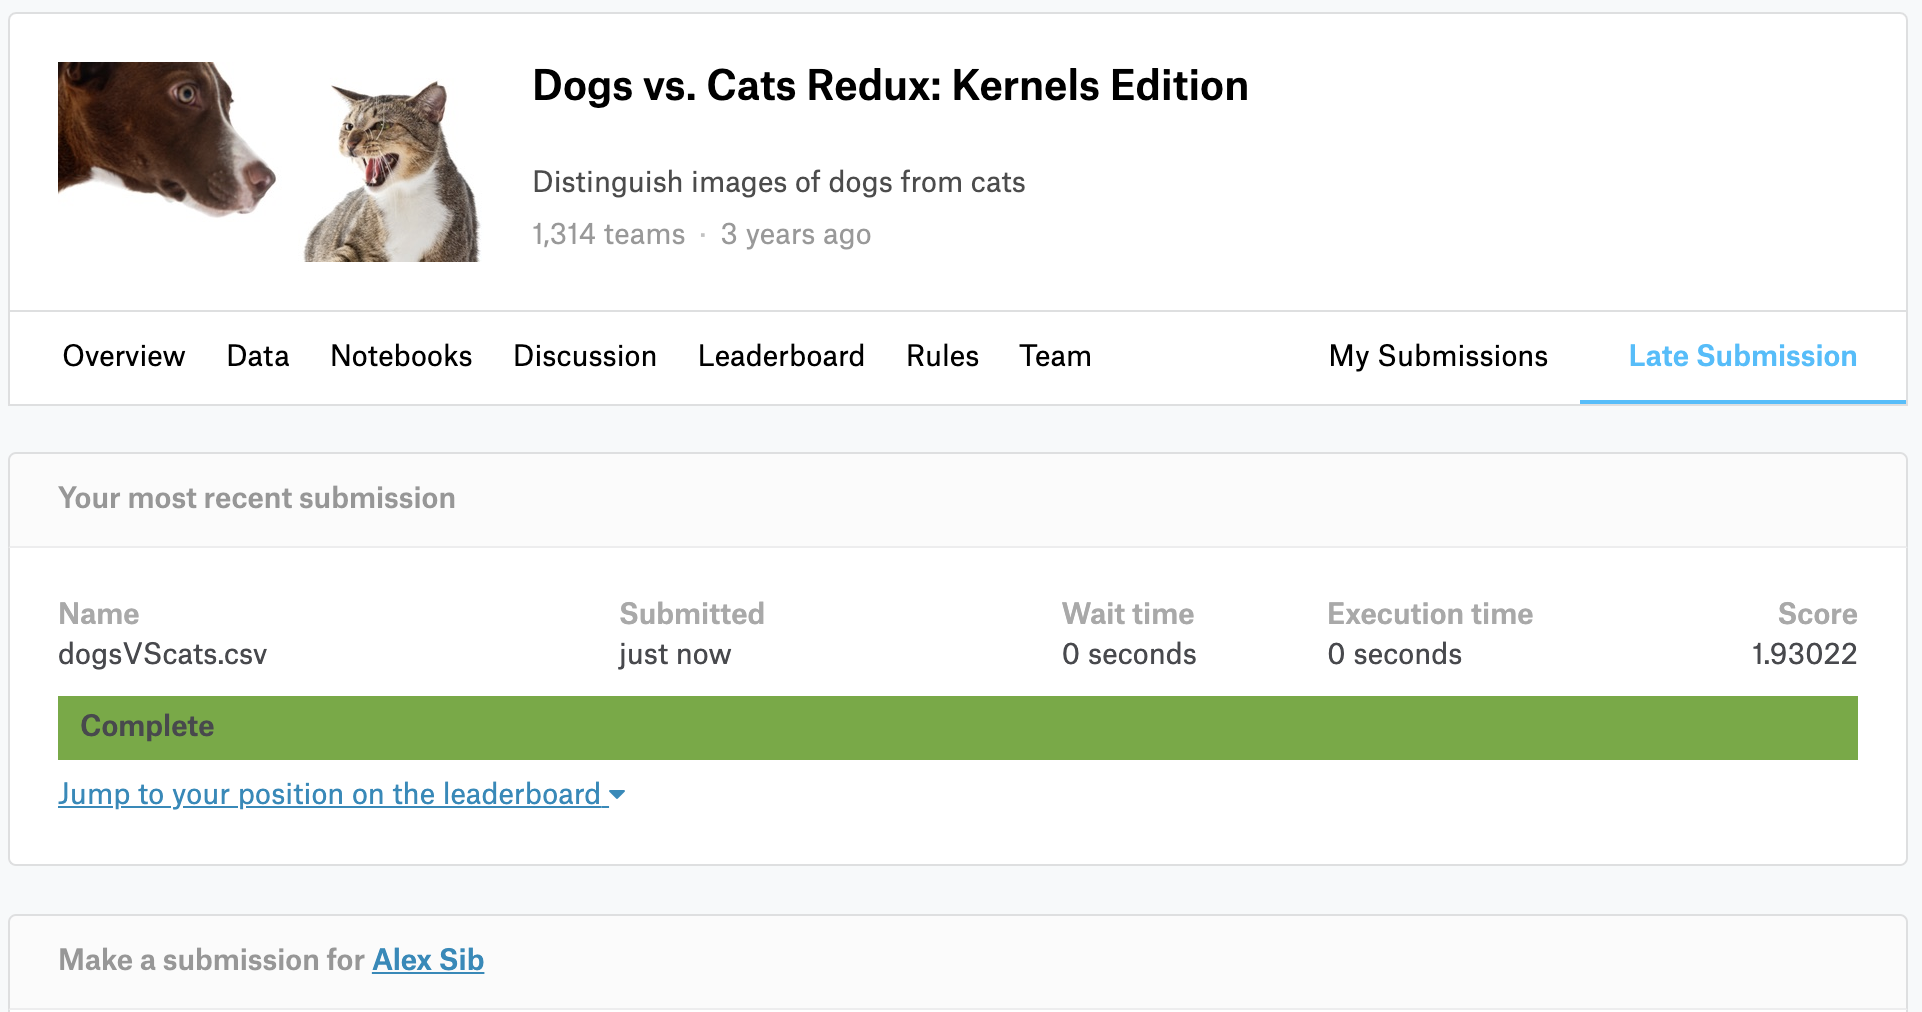

In [32]:
from IPython.display import Image
Image('/Users/aleksandr/Desktop/Screenshot 2019-11-22 at 15.38.03.png')

In [33]:
##

### VGG16

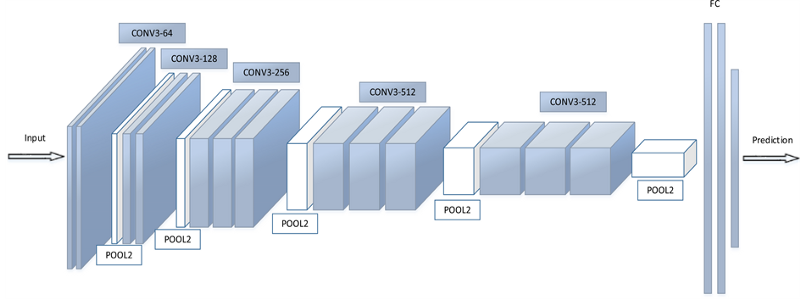

In [34]:
Image('/Users/aleksandr/Downloads/aml/aml_15/day6/image_0-8fa3b810.png')

In [35]:
train_data_dir = '/Users/aleksandr/Downloads/aml/aml_15/day6/data/train/'
test_data_dir = '/Users/aleksandr/Downloads/aml/aml_15/day6/data/test/'
vgg_model_path = '/Users/aleksandr/Downloads/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [36]:
epochs = 20
batch_size = 20
img_width, img_height = 150, 150
training_n_bound = 5000

Прочитать изображения и преобразовать их в массивы.

Генератор, который выдает (label, id, jpg_filename) кортеж. Здесь генератор Python используется для сокращения использования памяти.

In [37]:
def gen_image_label(directory):
    for root, dirs, files in os.walk(directory):
        for f in files:
            _, ext = os.path.splitext(f)
            if ext != '.jpg':
                continue
            basename = os.path.basename(f)
            splits = basename.split('.')
            if len(splits) == 3:
                label, id_, ext = splits
            else:
                label = None
                id_, ext = splits
            fullname = os.path.join(root, f)
            yield label, int(id_), fullname

Данные тренировок в DataFrame pandas

In [39]:
lst = list(gen_image_label(train_data_dir))
random.shuffle(lst)

if training_n_bound is not None:
    lst = lst[:training_n_bound]
    
train_df = pd.DataFrame(lst, columns=['label', 'id', 'filename'])
train_df = train_df.sort_values(by=['label', 'id'])
train_df['label_code'] = train_df.label.map({'cat':0, 'dog':1})

Данные тестов в DataFrame pandas

In [40]:
lst = list(gen_image_label(test_data_dir))
test_df = pd.DataFrame(lst, columns=['label', 'id', 'filename'])
test_df = test_df.sort_values(by=['label', 'id'])
test_df['label_code'] = test_df.label.map({'cat':0, 'dog':1})

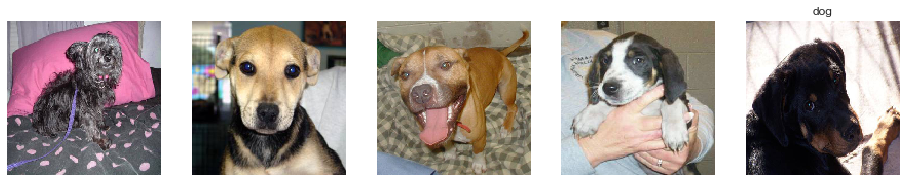

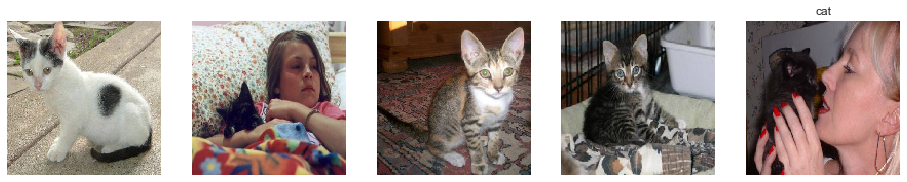

In [45]:
def display_images(label, n=5):
    fig = plt.figure(figsize=(16, 8))
    for j, fn in enumerate(train_df.loc[train_df.label == label].head(n).filename):
        img = load_img(fn, target_size=(img_width, img_height))
        fig.add_subplot(1, n, j + 1)
        f = plt.imshow(img)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.title(label)
    plt.show()

display_images('dog', 5)
display_images('cat', 5)

Генератор, который выдает изображение как массив np

In [47]:
def gen_label_image_batch(df, batch_size, n_max_batch=10):
    stacked = None
    img_arrays = []
    label_arrays = []
    n_batch = 0
    for index, row in df.iterrows():
        img_arrays.append(
            img_to_array(
                load_img(row['filename'], target_size=(img_width, img_height))))
        label_arrays.append(row['label_code'])
        if len(img_arrays) % batch_size == 0:
            yield np.array(label_arrays), np.stack(img_arrays)
            n_batch += 1
            img_arrays = []
            label_arrays = []
            if n_max_batch is not None and n_batch == n_max_batch:
                break
    if img_arrays and label_arrays:
        yield np.array(label_arrays), np.stack(img_arrays)

In [48]:
datagen = ImageDataGenerator(rescale=1./255)
def gen_embedding_batch(df, batch_size, n_max_batch=None):
    batches = gen_label_image_batch(df, 
                                    batch_size=batch_size, 
                                    n_max_batch=n_max_batch)
    model = applications.VGG16(include_top=False, 
                               weights=vgg_model_path)
    for i, (label, imgs) in tqdm(enumerate(batches)):
        generator = datagen.flow(
            imgs,
            label,
            batch_size=batch_size,
            shuffle=False)
        embedding_batch = model.predict_generator(
            generator, workers=4, verbose=0)
        yield embedding_batch

In [49]:
def gen_or_load_embedding(df, saved_embedding, force_gen=False):
    if os.path.exists(saved_embedding) and not force_gen:
        print('Loading embedding from %s...' % (saved_embedding,))
        embedding = np.load(open(saved_embedding, 'rb'))
    else:
        embedding = np.stack(
            gen_embedding_batch(df, 
                                batch_size=batch_size), 
            axis=0)
        embedding = embedding.reshape(
            [embedding.shape[0] * embedding.shape[1]] + list(embedding.shape[2:]))
        np.save(open(saved_embedding, 'wb'), embedding)
    return embedding

In [54]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import backend as K
# from sklearn.cross_validation import train_test_split
# K.tensorflow_backend._get_available_gpus()
# K.set_image_dim_ordering('tf')

[]

In [55]:
train_embeddings = gen_or_load_embedding(train_df, 'train_embeddings.npy', force_gen=True)
test_embeddings = gen_or_load_embedding(test_df, 'test_embeddings.npy', force_gen=False)

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':
250it [10:06,  2.54s/it]
625it [26:04,  2.69s/it]


In [56]:
[train_embeddings.shape, test_embeddings.shape]

[(5000, 4, 4, 512), (12500, 4, 4, 512)]

In [57]:
train_indices = np.nonzero((train_df.id[:train_embeddings.shape[0]] % 4 != 0).values)[0]
validate_indices = np.nonzero((train_df.id[:train_embeddings.shape[0]] % 4 == 0).values)[0]
train_labels = train_df.label_code.values[train_indices]
validation_labels = train_df.label_code.values[validate_indices]

In [58]:
embedding_fc_model = 'embedding_fc_model.h5'

In [82]:
model = Sequential()
model.add(Flatten(input_shape=train_embeddings.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.fit(train_embeddings[train_indices,:],
          train_labels,
          epochs=epochs,
          batch_size=batch_size,
#           epochs=30,
#           batch_size=30,
          validation_data=(train_embeddings[validate_indices,:], validation_labels))

Train on 3794 samples, validate on 1206 samples
Epoch 1/20
3794/3794 [==============================] - 3s 717us/step - loss: 0.5272 - accuracy: 0.7944 - val_loss: 0.2611 - val_accuracy: 0.8930
Epoch 2/20
3794/3794 [==============================] - 3s 663us/step - loss: 0.3050 - accuracy: 0.8672 - val_loss: 0.3451 - val_accuracy: 0.8524
Epoch 3/20
3794/3794 [==============================] - 3s 755us/step - loss: 0.2605 - accuracy: 0.8927 - val_loss: 0.2380 - val_accuracy: 0.8964
Epoch 4/20
3794/3794 [==============================] - 3s 674us/step - loss: 0.2354 - accuracy: 0.9085 - val_loss: 0.2779 - val_accuracy: 0.8947
Epoch 5/20
3794/3794 [==============================] - 3s 682us/step - loss: 0.2071 - accuracy: 0.9199 - val_loss: 0.2594 - val_accuracy: 0.8964
Epoch 6/20
3794/3794 [==============================] - 3s 682us/step - loss: 0.1814 - accuracy: 0.9296 - val_loss: 0.2636 - val_accuracy: 0.8972
Epoch 7/20
3794/3794 [==============================] - 3s 666us/step - loss

In [62]:
model.save_weights(embedding_fc_model)

In [85]:
from sklearn.metrics import f1_score, accuracy_score

pred_validation = model.predict(train_embeddings[validate_indices,:])
f1 = f1_score(validation_labels, pred_validation > 0.5)
acc = accuracy_score(validation_labels, pred_validation > 0.5)
(f1, acc)

(0.8885077186963979, 0.8922056384742952)

In [86]:
pred_test = model.predict(test_embeddings)
pred_test.shape

(12500, 1)

In [87]:
results = pd.DataFrame({'id': pd.Series(test_df.id.values[:pred_test.shape[0]]),
                        'label': pd.Series(pred_test.T[0])})

results.to_csv('submission4.csv', index=False)

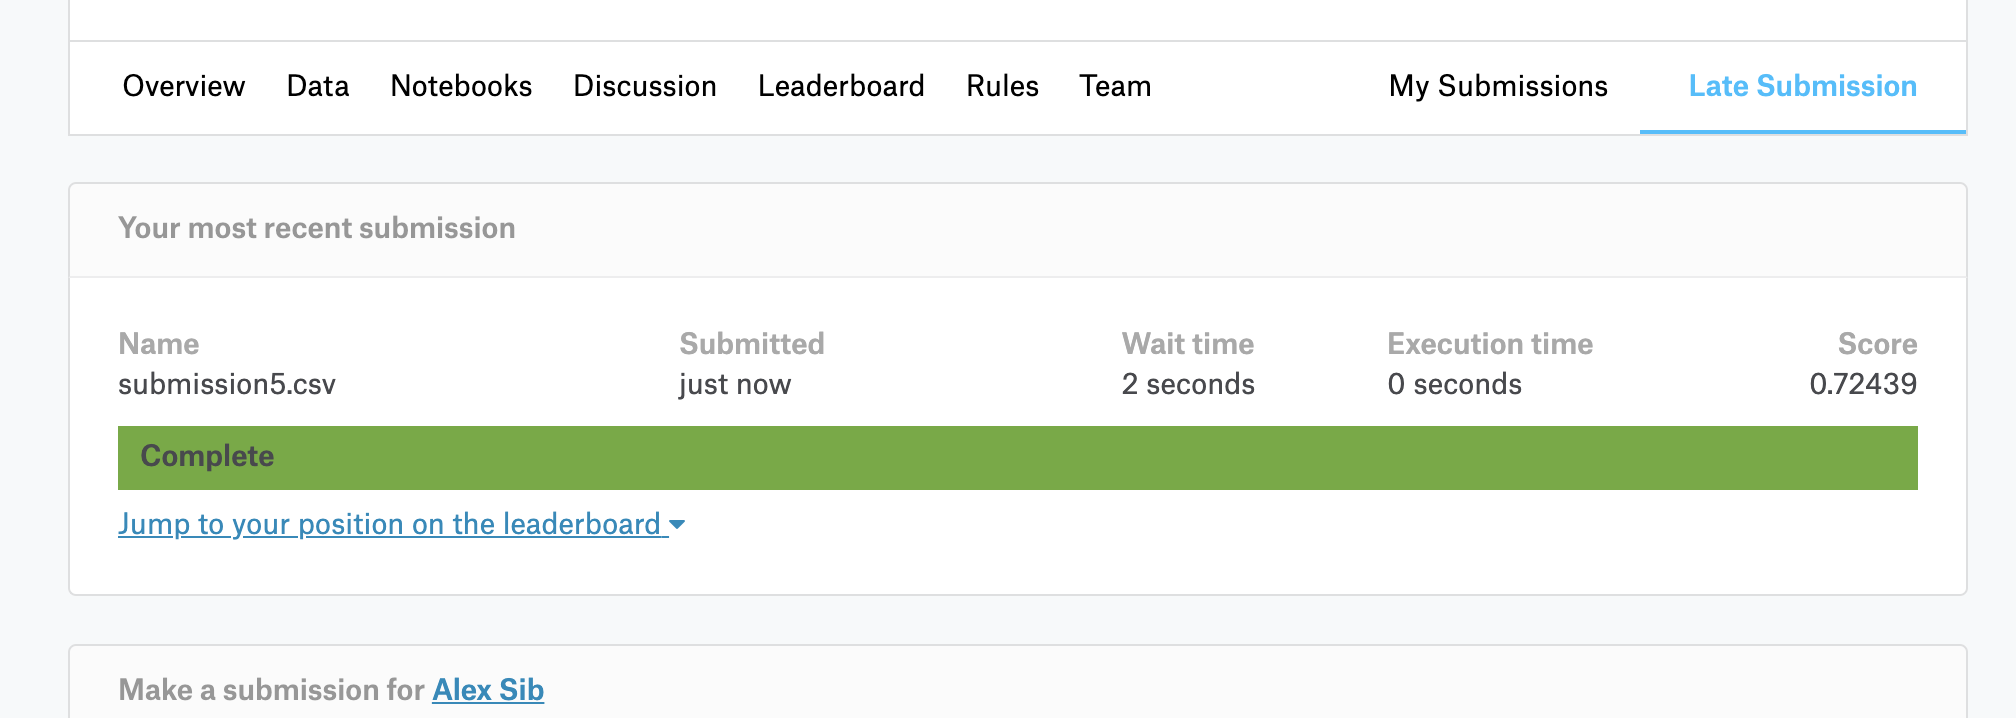

In [92]:
Image('/Users/aleksandr/Desktop/Screenshot 2019-11-22 at 17.26.39.png')

Пробуем другие модели.

In [94]:
from glob import glob

In [96]:
train_files = glob('/Users/aleksandr/Downloads/aml/aml_15/day6/data/train/*.jpg')
test_files = glob('/Users/aleksandr/Downloads/aml/aml_15/day6/data/test/*.jpg')

IMG_SIZE = (224, 224)

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    array/=255.
    #ImageDataGenerator(rescale=1. / 255)
    return  array#preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [89]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [104]:
from keras.applications.vgg16 import VGG16 as vgg_16

vgg16 = vgg_16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [105]:
for layer in vgg16.layers:
    layer.trainable = False

In [106]:
vgg16.trainable = False

In [107]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [109]:
model_vgg16 = models.Sequential()
model_vgg16.add(vgg16)
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(Flatten())
model_vgg16.add(Dense(512, activation='relu'))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(1, activation='sigmoid'))

In [110]:
model_vgg16.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               12845568  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)               

In [111]:
def load_image(path, target_size =(224,224)):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

In [112]:
model_vgg16.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [116]:
from random import shuffle
from keras.applications.vgg16 import preprocess_input

In [118]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
history_vgg16 = model_vgg16.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=20,  # число вызовов генератора за эпоху
        epochs=20,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/20
20/20 [==============================] - 190s 10s/step - loss: 0.2409 - accuracy: 0.9312 - val_loss: 0.5565 - val_accuracy: 0.9000
Epoch 2/20
20/20 [==============================] - 176s 9s/step - loss: 0.1012 - accuracy: 0.9672 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 3/20
20/20 [==============================] - 183s 9s/step - loss: 0.1250 - accuracy: 0.9656 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 4/20
20/20 [==============================] - 192s 10s/step - loss: 0.1422 - accuracy: 0.9422 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 189s 9s/step - loss: 0.1213 - accuracy: 0.9609 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 197s 10s/step - loss: 0.0966 - accuracy: 0.9688 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 196s 10s/step - loss: 0.0969 - accuracy: 0.9672 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 8/2

In [119]:
model_vgg16.save('cats-dogs-VGG16.hdf5')

In [120]:
predicts_vgg16= model_vgg16.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

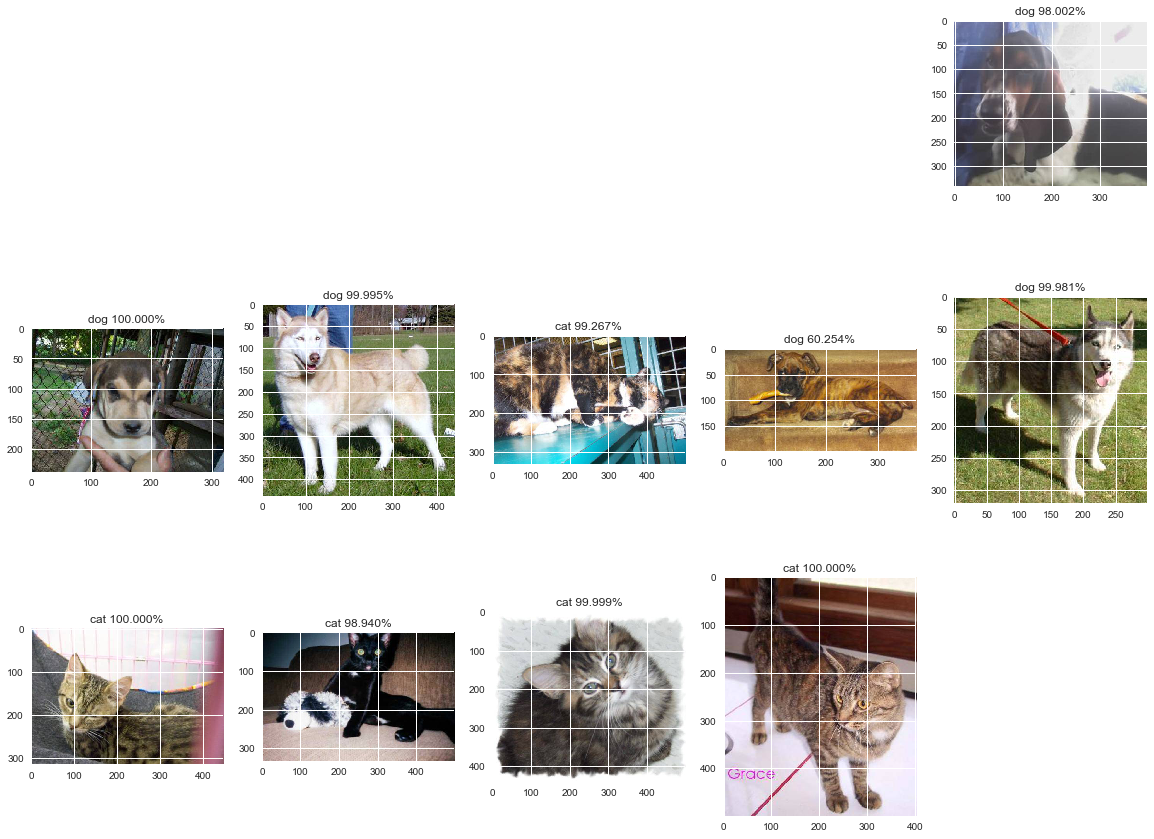

In [121]:
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], predicts_vgg16[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    if score < 0.5:
        plt.title('cat %.3f%%' % (100 - score * 100))
    else:
        plt.title('dog %.3f%%' % (score * 100))
    plt.imshow(plt.imread(path));

In [122]:
# with open('submit_model_vgg16.txt', 'w') as dst:
#     dst.write('id,label\n')
#     for path, score in zip(test_files,predicts_vgg16):
#         dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [124]:
TEST_DIR = '/Users/aleksandr/Downloads/aml/aml_15/day6/data/test/'
test_images_dogs_cats = [TEST_DIR+i for i in os.listdir(TEST_DIR)]
counter = range(1, len(test_images_dogs_cats) + 1)
solution = pd.DataFrame({"id": counter, "label":list(predicts_vgg16)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(
        lambda x: str(x).lstrip('[').rstrip(']')).astype(np.float64)

solution.to_csv("submit_model_vgg16.csv", index = False)

И еще одна модель

In [126]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing import image
from keras.applications import VGG16

In [127]:
base_dir = '/Users/aleksandr/Downloads/aml/aml_15/day6/data/'
train_dir = os.path.join(base_dir, 'train/')
test_dir = os.path.join(base_dir, 'test/')

In [128]:
train_images = []
for i in os.listdir(train_dir):
    train_images.append(train_dir+i)
    
test_images = []
for i in os.listdir(test_dir):
    test_images.append(test_dir+i)

In [129]:
conv_m = VGG16(weights='imagenet',
               include_top=False,
               input_shape=(150,150,3))

In [130]:
conv_m.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Выше стандартная предобученная VGG16 из коробки

In [131]:
model = models.Sequential()
model.add(conv_m)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [132]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [133]:
conv_m.trainable = False

In [134]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

In [135]:
train = train_images[:2000]
train_numpy = []

for i in train:
    img = image.load_img(i, target_size=(150,150))
    img = image.img_to_array(img)
    img = img/255
    train_numpy.append(img)
    
train_numpy = np.array(train_numpy)

In [136]:
train_y = []

for i in train:
    if 'dog.' in i:
        train_y.append(1)
    else:
        train_y.append(0)

In [137]:
history = model.fit(
    train_numpy, 
    train_y, 
    batch_size=100, 
    epochs=20, 
    validation_split=0.25
)

Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 241s 161ms/step - loss: 0.6816 - acc: 0.5747 - val_loss: 0.5799 - val_acc: 0.7320
Epoch 2/20
1500/1500 [==============================] - 205s 137ms/step - loss: 0.5332 - acc: 0.7773 - val_loss: 0.4933 - val_acc: 0.8160
Epoch 3/20
1500/1500 [==============================] - 211s 141ms/step - loss: 0.4592 - acc: 0.8280 - val_loss: 0.4373 - val_acc: 0.8420
Epoch 4/20
1500/1500 [==============================] - 214s 143ms/step - loss: 0.4076 - acc: 0.8540 - val_loss: 0.4001 - val_acc: 0.8620
Epoch 5/20
1500/1500 [==============================] - 223s 149ms/step - loss: 0.3711 - acc: 0.8700 - val_loss: 0.3731 - val_acc: 0.8680
Epoch 6/20
1500/1500 [==============================] - 239s 159ms/step - loss: 0.3430 - acc: 0.8813 - val_loss: 0.3543 - val_acc: 0.8720
Epoch 7/20
1500/1500 [==============================] - 215s 144ms/step - loss: 0.3169 - acc: 0.8887 - val_loss: 0.3400 - val

In [138]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

In [139]:
epochs = range(1, len(loss)+1)

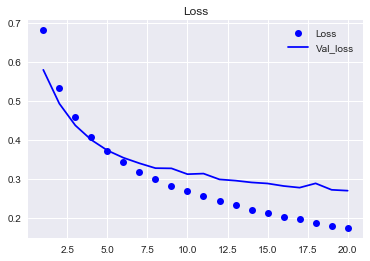

In [140]:
plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, val_loss, 'b', label='Val_loss')
plt.title("Loss")
plt.legend()
plt.show()

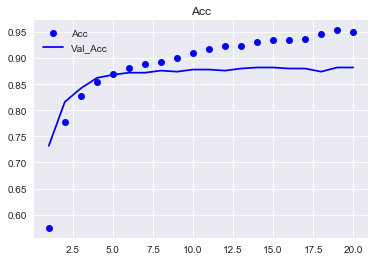

In [141]:
plt.plot(epochs, acc, 'bo', label='Acc')
plt.plot(epochs, val_acc, 'b', label='Val_Acc')
plt.title("Acc")
plt.legend()
plt.show()

In [142]:
pred = model.predict(train_numpy[1:2])

In [144]:
test_numpy = []

for i in test_images:
    if '/Users/aleksandr/Downloads/aml/aml_15/day6/data/test/test' in i :
        continue
    test_img = image.load_img(i, target_size=(150,150))
    test_img = image.img_to_array(test_img)
    test_img = test_img/255
    test_numpy.append(test_img)
    
test_numpy = np.array(test_numpy)

In [146]:
test_answer = model.predict(test_numpy)

In [147]:
test_id = []

for i in os.listdir(test_dir):
    if 'test' in i :
        continue    
    num = i.split('.')[0]
    test_id.append(num)

In [148]:
test_id_sub = pd.Series(test_id, name='id')
results = pd.Series(test_answer.reshape(12500,), name='label')
submission = pd.concat([test_id_sub, results], axis=1)

In [149]:
submission

,id,label
0,9733,0.177325
1,63,0.102009
2,6400,0.972873
3,823,0.994427
4,4217,0.291078
5,3578,0.290838
6,10321,0.951764
7,2666,0.293189
8,5109,0.284576
9,11981,0.065860


In [150]:
submission.to_csv("Cats_and_Dogs_CNN_VGG.csv", index=False)

In [153]:
model.save('dogsVSCatsVGG16.hdf5')

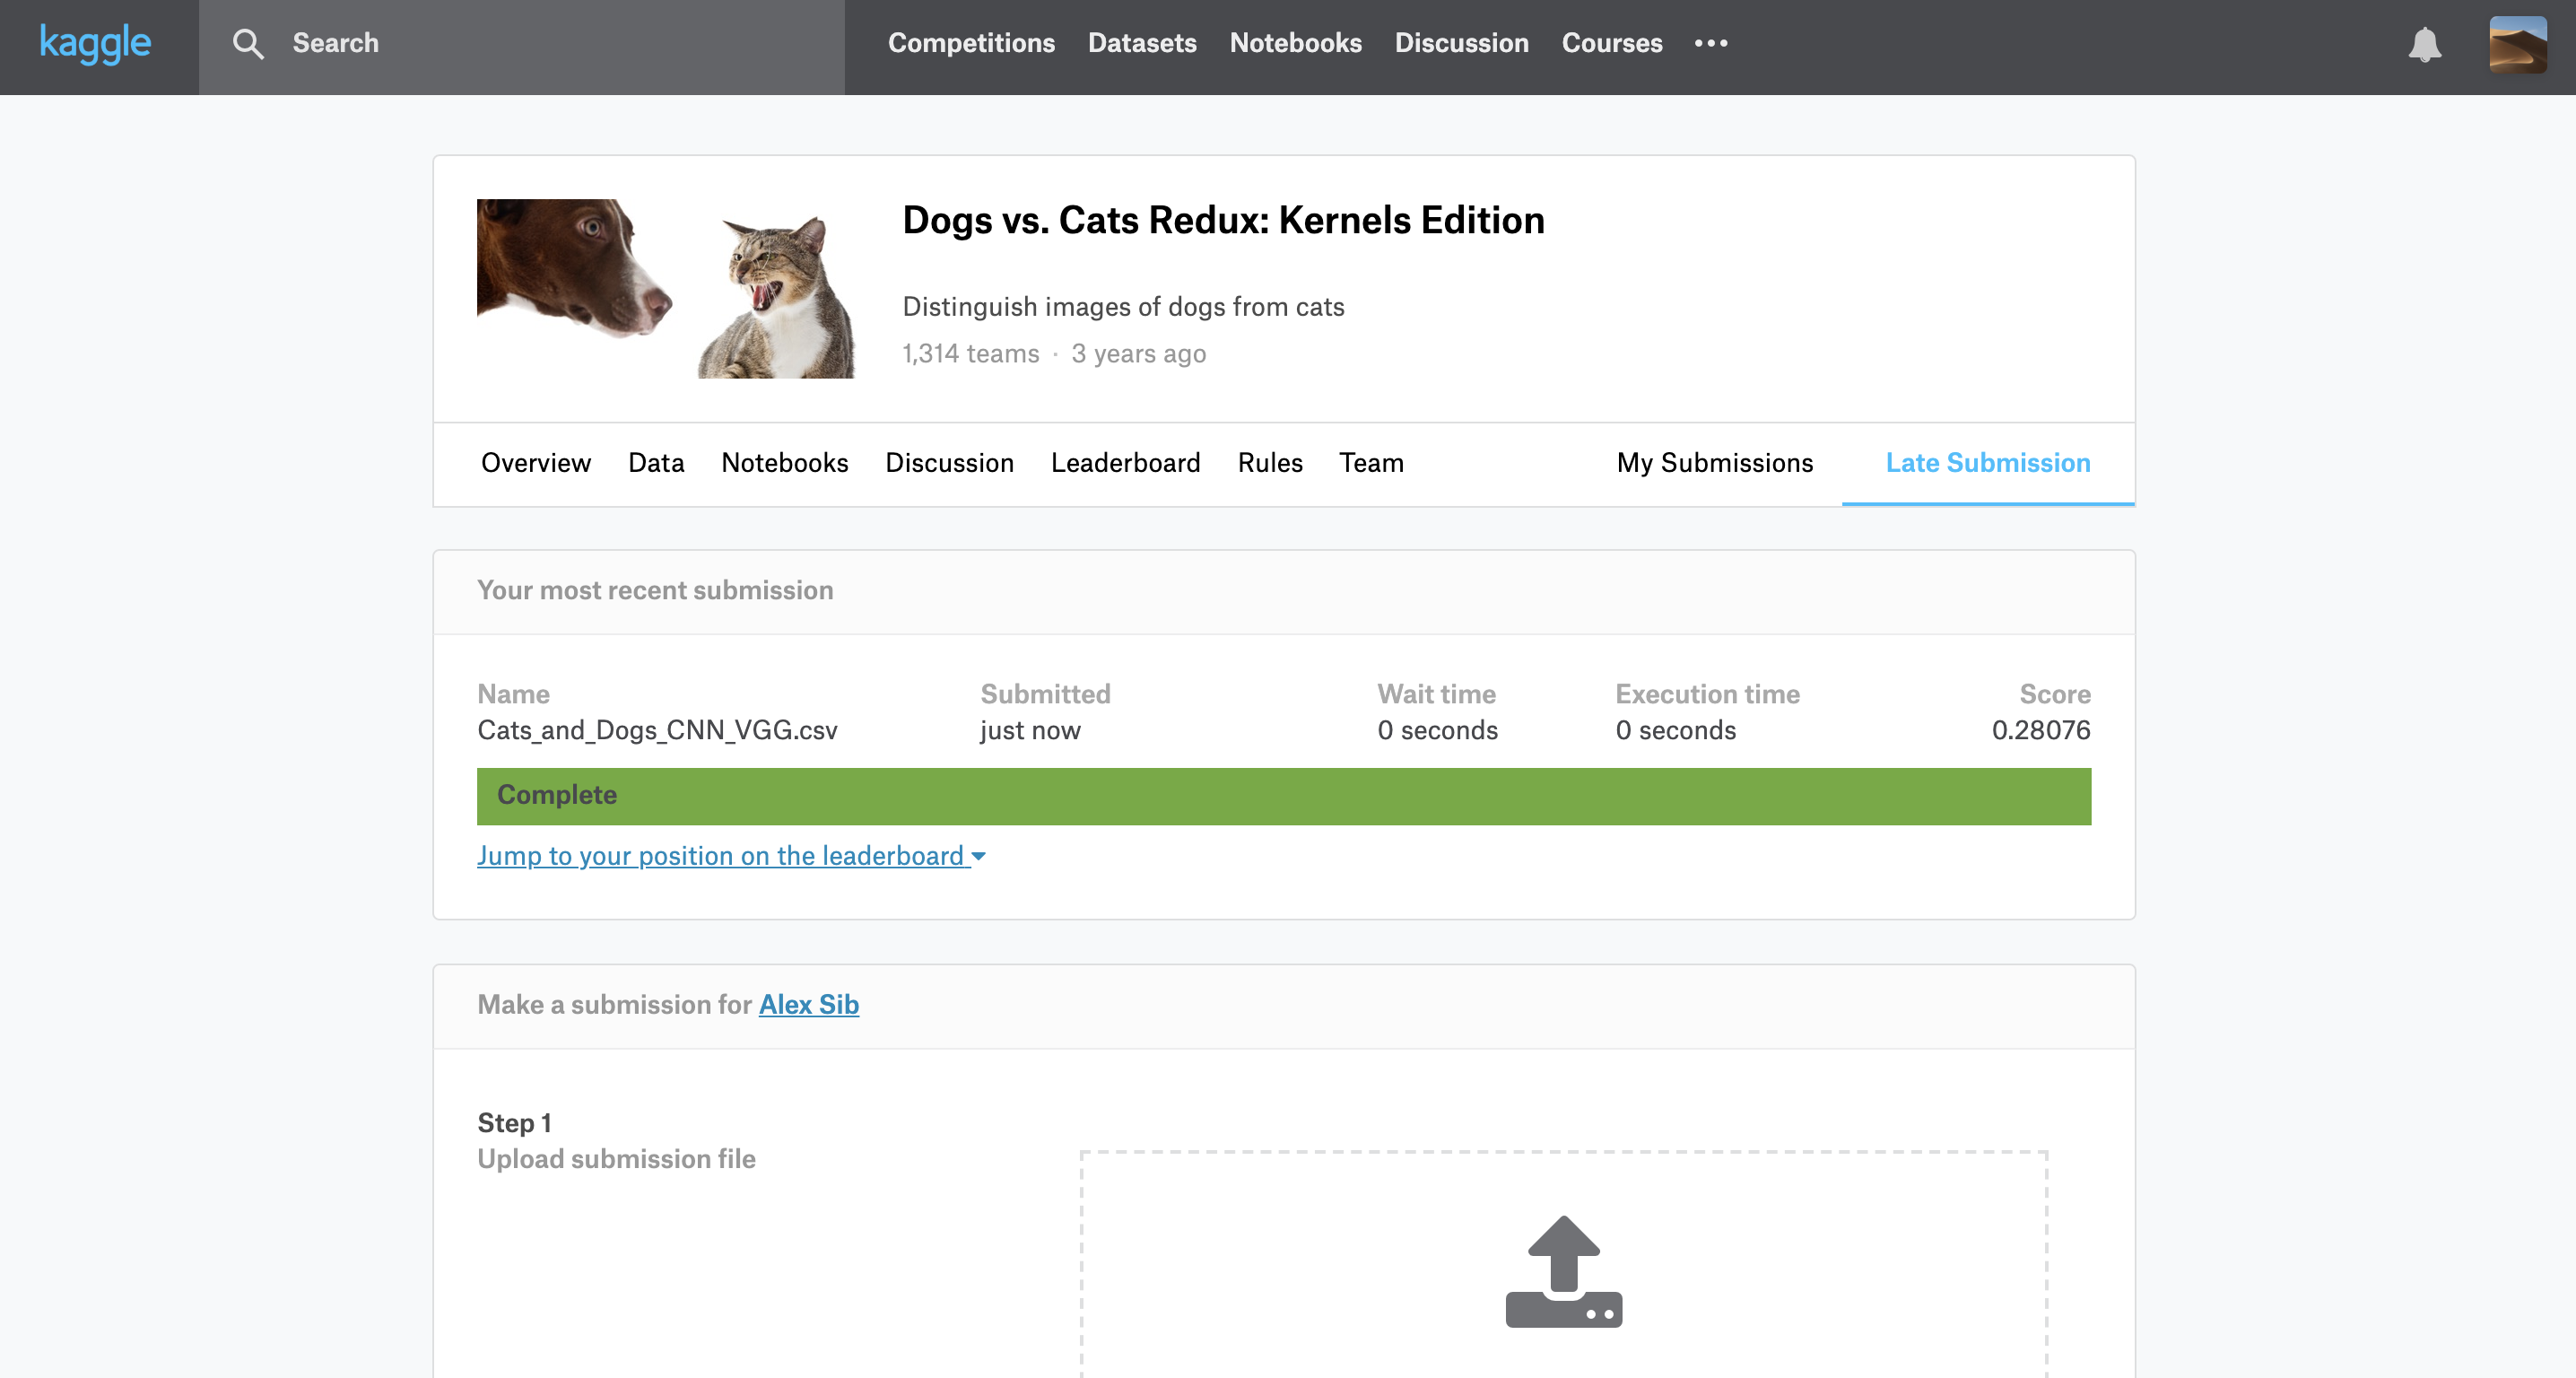

In [151]:
Image('/Users/aleksandr/Desktop/Screenshot 2019-11-22 at 22.24.08.png')

My Submissions

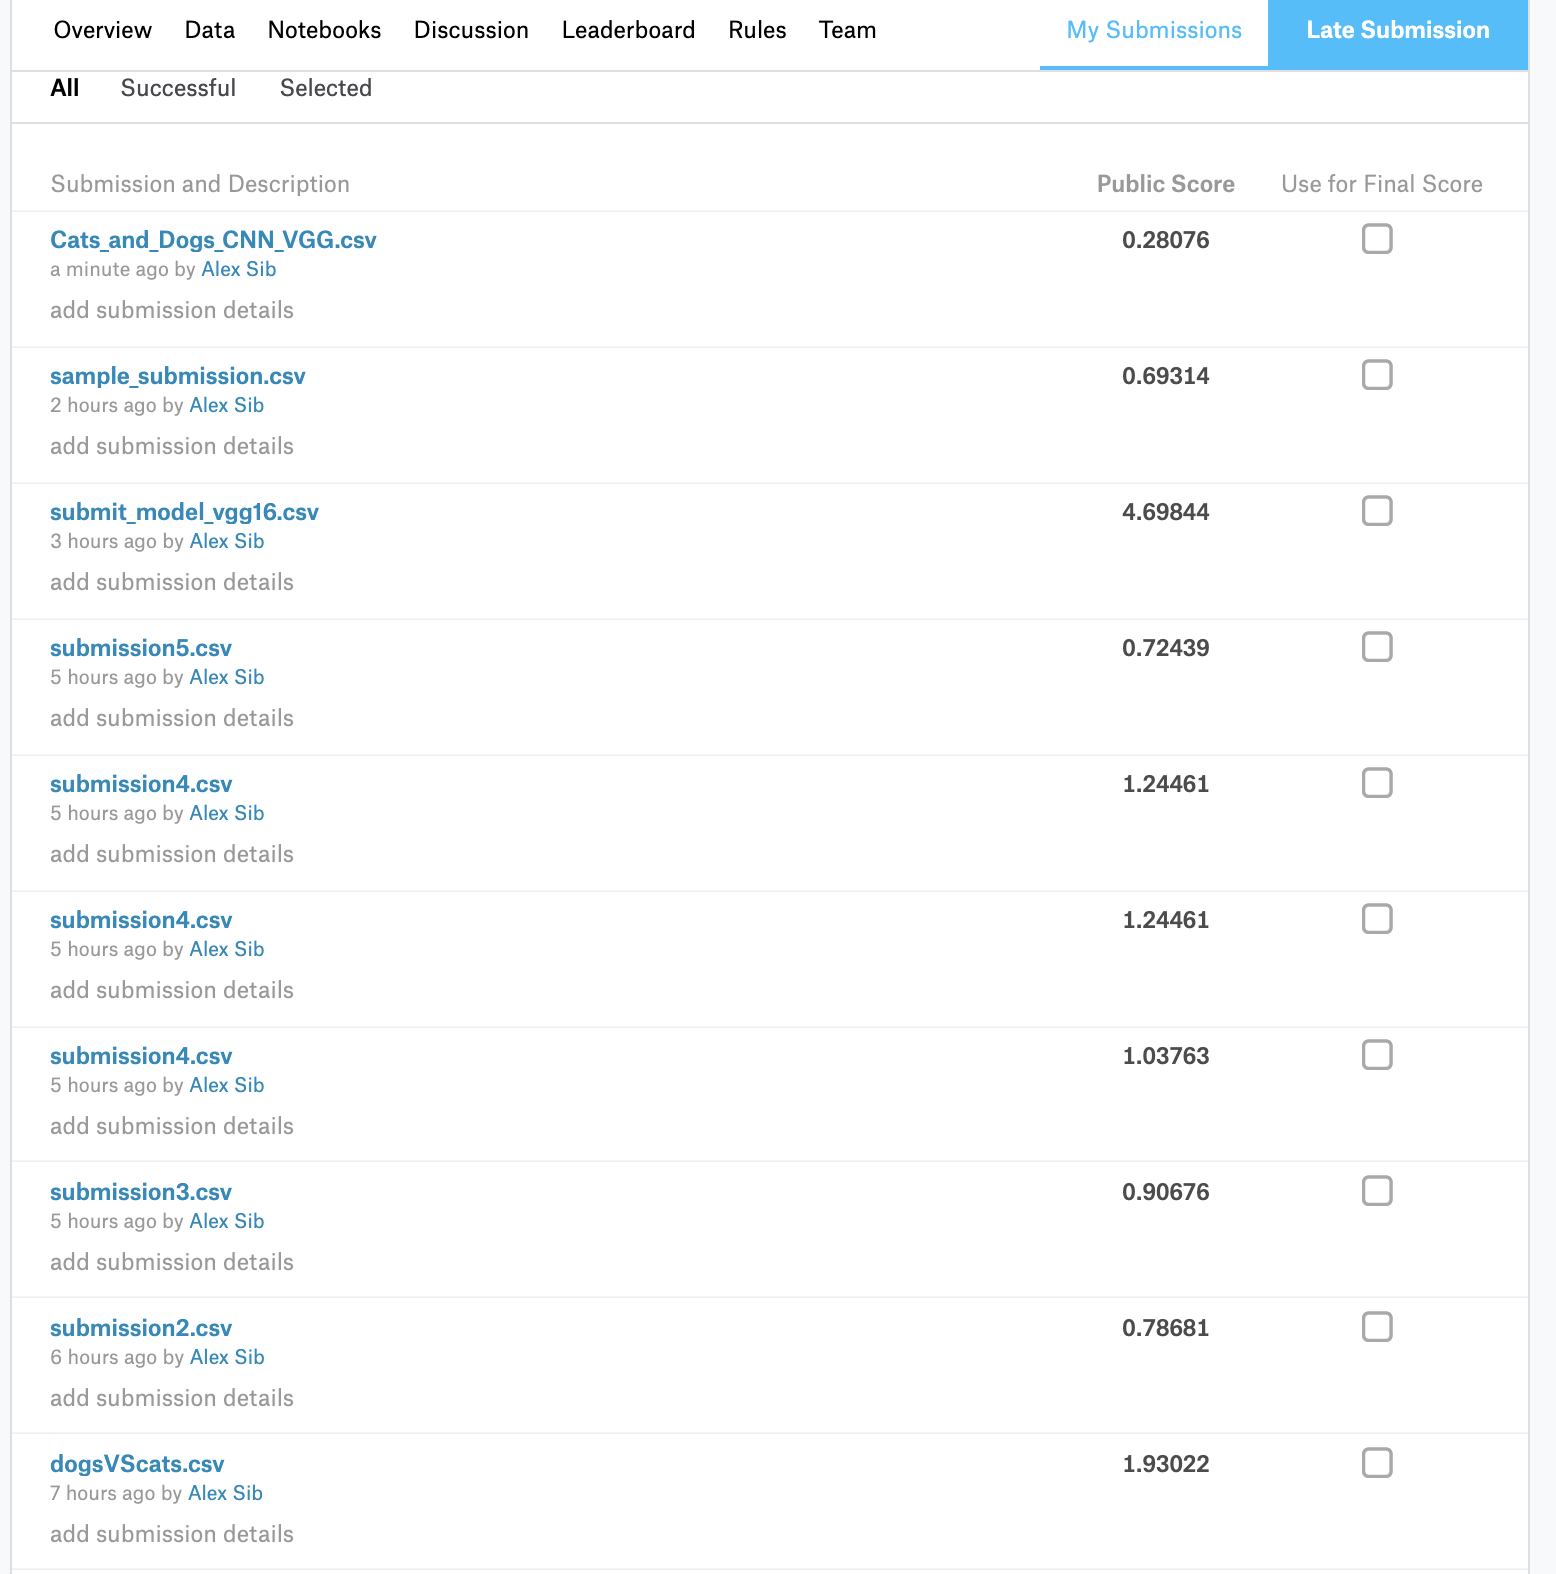

In [152]:
Image('/Users/aleksandr/Desktop/Screenshot 2019-11-22 at 22.24.59.png')

In [ ]:
pass